<h2>Проект: Принятие решений в бизнесе</h2>

<p><b>Контекст</b></p>
<p>Мы — аналитики крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки. 
Приоритизируем гипотезы, запустим A/B-тест и проанализируйем результаты.</p>

<p>Этапы работы:</p>
<ul>
    <li>провести обработку данных</li>
    <li>выполнить приоритизацию гипотез</li>
    <li>провести A/B-тест и проанализировать результаты.</li>
</ul>

<h3>Обработка данных</h3>

In [1]:
from dotenv import load_dotenv
from http import HTTPStatus
import logging
from math import pi
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import re
import requests
from scipy import stats as st
import sys
import warnings

load_dotenv()

# настроимся на приятный вечер
register_matplotlib_converters()
warnings.filterwarnings('ignore')

logging.basicConfig(
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO)


# будем следить за поведением программы и за пользователями
# с помощью кастомного исключения на все случаи жизни
class BaseException(Exception):
    """Напишем базовое исключение"""

    def __init__(self, text):
        """активация..."""
        self.text = text

In [2]:
PATH_ERROR_TEXT = 'некоррекнто прописан путь к данным'
def read_file(path_1: str, path_2: str) -> pd.DataFrame:
    """
    Функция считывает данные из файла и
    возвращает дата фрейм
    """
    # проверим, что файл существует, также стоит проверить
    # что это именно файл, если это не так, то нет смысла продолжать
    if os.path.exists(path_1) and os.path.isfile(path_1) or requests.get(path_1).status_code == HTTPStatus.OK:
        logging.info('works online')
        data = pd.read_csv(path_1)
        logging.info('read file sucsess')
        return data
    elif os.path.exists(path_2) and os.path.isfile(path_2):
        logging.info('works lokaly')
        data = pd.read_csv(path_2)
        logging.info('read file sucsess')
        return data
    else:
        logging.critical(PATH_ERROR_TEXT)
        raise BaseException(PATH_ERROR_TEXT) and sys.exit()


def get_full_information(data: pd.DataFrame) -> None:
    """
    Функция дает нам полное
    представление о данных
    """
    logging.info('первое представление о данных')
    for _ in [data.head(), data.describe()]:
        display(_)
        print("*"*100)
    data.info()
    data.hist(figsize=(15, 10))
    plt.show();


def check_names_columns(data: pd.DataFrame) -> list[str]:
    """
    Функция проверяет, соответствуют
    ли имена колонок snake_style
    """
    columns_to_change = []
    pattern = r"^[a-z]+(_[a-z]+)*$"
    for column in data.columns:
        match = re.match(pattern, column)
        if match:
            continue
        else:
            columns_to_change.append(column)
    logging.info('изменим название колонок:')
    logging.info(columns_to_change)
    return columns_to_change


def test_check_names_columns():
    # Тестовый датафрейм с корректными именами колонок
    df1 = pd.DataFrame({'first_name': ['John', 'Jane'], 'last_name': ['Doe', 'Smith']})
    assert check_names_columns(df1) == []

    # Тестовый датафрейм с некорректными именами колонок
    df2 = pd.DataFrame({'FirstName': ['John', 'Jane'], 'last name': ['Doe', 'Smith']})
    assert check_names_columns(df2) == ['FirstName', 'last name']

    # Тестовый датафрейм с пустыми данными
    df3 = pd.DataFrame()
    assert check_names_columns(df3) == []

    # Тестовый датафрейм с одной колонкой
    df4 = pd.DataFrame({'name': ['John', 'Jane']})
    assert check_names_columns(df4) == []

    # Тестовый датафрейм с двумя колонками, одна из которых корректная
    df5 = pd.DataFrame({'first_name': ['John', 'Jane'], 'last name': ['Doe', 'Smith']})
    assert check_names_columns(df5) == ['last name']
    print('OK')


NOT_LIST = 'входные данные должны быть в форме списка'
NOT_STR = 'в списке должны быть строки'
def change_name_columns(columns_to_change: list[str]) -> dict[str, str]:
    """
    Функция возвращает словарь,
    ключ- неправильное название колонки
    значение - верное
    """
    def sup_right_name(column:str) ->str:
        cont: list[str] = list(column)
        new_name: str = ''
        while cont:
            char = cont.pop()
            if len(cont) == 0:
                new_name = char.lower() + new_name
            elif char.isupper():
                new_name = f'_{char.lower()}' + new_name
            else:
                new_name = char + new_name
        return new_name
    right_names = []
    # проверим, что нам подсунули на входе,
    # это нужно, для обеспечения устойчивости программы
    if not isinstance(columns_to_change, list):
        raise BaseException(NOT_LIST)
    for column in columns_to_change:
        if not isinstance(column, str):
            raise BaseException(NOT_STR)
    else:
        for column in columns_to_change:
            if len(column.split()) != 1:
                column = '_'.join(column.split())
                column = column.lower()
            elif column.isupper():
                column = column.lower()
            elif re.match(r'^[a-zA-Z]+$', column):
                column = sup_right_name(column)
            right_names.append(column)
    columns = {c:r for c,r in zip(columns_to_change, right_names)}
    return columns


def test_change_name_columns():
    # Тестовый список с корректными названиями колонок
    columns1 = ['first_name', 'last_name']
    assert change_name_columns(columns1) == {'first_name': 'first_name', 'last_name': 'last_name'}

    # Тестовый список с некорректными данными - не список
    columns2 = 'first_name, last_name'
    try:
        change_name_columns(columns2)
    except BaseException as e:
        assert str(e) == 'входные данные должны быть в форме списка'

    # Тестовый список с некорректными данными - не строки
    columns3 = ['first_name', 123]
    try:
        change_name_columns(columns3)
    except BaseException as e:
        assert str(e) == 'в списке должны быть строки'

    # Тестовый список с некорректными названиями колонок
    columns4 = ['FirstName', 'last name']
    assert change_name_columns(columns4) == {'FirstName': 'first_name', 'last name': 'last_name'}

    # Тестовый список с одним элементом
    columns5 = ['name']
    assert change_name_columns(columns5) == {'name': 'name'}

    # Тестовый список с элементами, требующими преобразований
    columns6 = ['First name', 'LASTNAME', 'Age']
    assert change_name_columns(columns6) == {'First name': 'first_name', 'LASTNAME': 'lastname', 'Age': 'age'}
    print('OK')


def find_nan(data: pd.DataFrame) -> dict:
    """
    Функция считает по каждой колонке, сколько в ней пропусков,
    если пропусков 0, то с колонкой все хорошо
    и ее мы трогать не будем
    """
    return {column: data[column].isna().sum()/len(data)
            for column in data.columns
            if data[column].isna().sum() != 0}


def test_find_nan():
    # Тестовый датафрейм с пропусками
    df1 = pd.DataFrame({'A': [1, 2, None, 4], 'B': [None, 6, 7, 8], 'C': [9, 10, 11, None]})
    assert find_nan(df1) == {'A': 0.25, 'B': 0.25, 'C': 0.25}

    # Тестовый датафрейм без пропусков
    df2 = pd.DataFrame({'A': [1, 2, 3, 4], 'B': [5, 6, 7, 8], 'C': [9, 10, 11, 12]})
    assert find_nan(df2) == {}
    print('OK')


def drop_nan_less_five_percent(data: pd.DataFrame) -> pd.DataFrame:
    """
    Функция удаляет строки по колонкам,
    если кол-во пропусков в них составляло
    менее 5 процентов
    """
    columns_with_nan = find_nan(data)
    for column, percent in columns_with_nan.items():
        if percent < .05:
            data = data[data[column].notna()]
    return data


def test_drop_nan_less_five_percent():
    # Тестовый датафрейм с пропусками в колонке A (менее 5%)
    df1 = pd.DataFrame({'a': [None] + [i for i in range(20)], 'b': [i for i in range(21)]})
    assert drop_nan_less_five_percent(df1).equals(pd.DataFrame(data={'a': [float(i) for i in range(20)],
                                                                     'b':[i for i in range(1, 21)]},
                                                               index = [i for i in range(1,21)]))

    # Тестовый датафрейм с пропусками в колонках A и B (более 5%)
    df2 = pd.DataFrame({'A': [None, None, None, None], 'B': [None, None, None, None], 'C': [9, 10, 11, 12]})
    assert drop_nan_less_five_percent(df2).equals(df2)

    # Тестовый датафрейм без пропусков
    df3 = pd.DataFrame({'A': [1, 2, 3, 4], 'B': [5, 6, 7, 8], 'C': [9, 10, 11, 12]})
    assert drop_nan_less_five_percent(df3).equals(df3)
    print('OK')


def works_dupblicates(data: pd.DataFrame) -> pd.DataFrame:
    """
    Функция работает с дубликатами
    """
    # приведем значения колонок к нижнему регистру
    for column in data.columns:
        if data.dtypes[column] == 'object':
            data[column] = data[column].str.lower()
    # если появились дубликаты дропнем их
    if data.duplicated().sum() > 0:
        logging.info('нашли дубликаты')
        data = data.drop_duplicates()
    else:
        logging.info('дубликатов не найдено')
    return data


def test_works_duplicates():
    df = pd.DataFrame({'name': ['Alice', 'Bob', 'Charlie', 'alice'],
                       'age': [25, 30, 35, 25],
                       'date': ['2020-01-01', '2020-02-02', '2020-03-03', '2020-01-01']})
    df_result = works_dupblicates(df)
    assert len(df_result) == 3
    assert not df_result.duplicated().any()
    print('ОК')


def change_type_to_date(data: pd.DataFrame) -> pd.DataFrame:
    """
    Меняет формат на время
    """
    pattern = r'\d{4}-\d{2}-\d{2}'
    for column in data.columns:
        match = re.match(pattern, str(data[column][0]))
        if match:
            data[column] = pd.to_datetime(data[column])
            logging.info('поменяли на временной формат колоку')
            logging.info(column)
    return data


def test_change_type_to_date():
    df = pd.DataFrame({'name': ['Alice', 'Bob', 'Charlie', 'alice'],
                       'age': [25, 30, 35, 40],
                       'date': ['2020-01-01', '2020-02-02', '2020-03-03', '2020-04-04']})
    df_result = change_type_to_date(df)
    assert isinstance(df_result['date'][0], pd.Timestamp)
    assert not isinstance(df_result['name'][0], pd.Timestamp)
    print('OK')


def process_data(path_1: str, path_2: str)->pd.DataFrame:
    """
    Функция содержит основную логику
    первичной обработки данных
    """
    try:
        # читаем данные и выводим всю правду о них
        data = read_file(path_1, path_2)
        get_full_information(data)

        # работаем с названиями колонок
        columns_to_change = check_names_columns(data)
        if len(columns_to_change) > 0:
            columns_with_correct_name = change_name_columns(columns_to_change)
            data = data.rename(columns=columns_with_correct_name)

        # поработаем с пропусками
        if len(find_nan(data)) > 0:
            data = drop_nan_less_five_percent(data)
            display(pd.DataFrame(data=find_nan(data)).style.background_gradient('coolwarm'))
        else:
            logging.info('пропусков не нашел')


        # уничтожаем дубликаты
        data = works_dupblicates(data)

        # приводим к нужным типам
        data = change_type_to_date(data)

        # фуххх, добрались до конца
        logging.info('выдыхай, бобер, первичная обработка данных окончена')
        return data

    # если были ошибки, не стоит их скрывать, скажем об этом прямо
    except BaseException as error_message:
        return(error_message)

In [3]:
def testing():
    test_check_names_columns()
    test_change_name_columns()
    test_find_nan()
    test_drop_nan_less_five_percent()
    test_works_duplicates()
    test_change_type_to_date()


testing()

2024-05-01 19:47:04,422 - INFO - изменим название колонок:
2024-05-01 19:47:04,425 - INFO - []
2024-05-01 19:47:04,428 - INFO - изменим название колонок:
2024-05-01 19:47:04,430 - INFO - ['FirstName', 'last name']
2024-05-01 19:47:04,433 - INFO - изменим название колонок:
2024-05-01 19:47:04,434 - INFO - []
2024-05-01 19:47:04,435 - INFO - изменим название колонок:
2024-05-01 19:47:04,437 - INFO - []
2024-05-01 19:47:04,439 - INFO - изменим название колонок:
2024-05-01 19:47:04,440 - INFO - ['last name']
2024-05-01 19:47:04,458 - INFO - нашли дубликаты
2024-05-01 19:47:04,470 - INFO - поменяли на временной формат колоку
2024-05-01 19:47:04,472 - INFO - date


OK
OK
OK
OK
ОК
OK


2024-05-01 19:47:04,503 - INFO - обработка гипотез
2024-05-01 19:47:04,819 - INFO - works online
2024-05-01 19:47:05,123 - INFO - read file sucsess
2024-05-01 19:47:05,126 - INFO - первое представление о данных


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


****************************************************************************************************


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


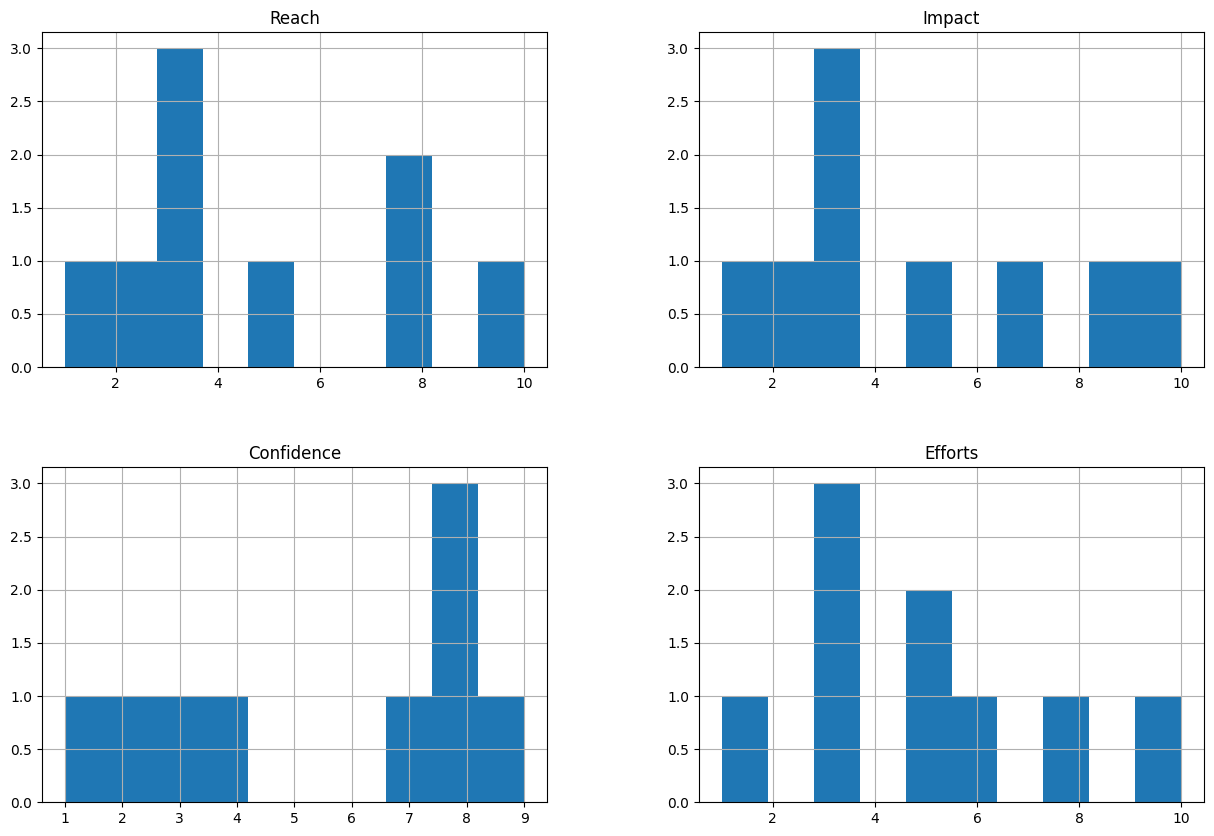

2024-05-01 19:47:06,027 - INFO - изменим название колонок:
2024-05-01 19:47:06,029 - INFO - ['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts']
2024-05-01 19:47:06,035 - INFO - пропусков не нашел
2024-05-01 19:47:06,039 - INFO - дубликатов не найдено
2024-05-01 19:47:06,041 - INFO - выдыхай, бобер, первичная обработка данных окончена
2024-05-01 19:47:06,042 - INFO - обработка гипотез завершена
2024-05-01 19:47:06,044 - INFO - обработка заказов
2024-05-01 19:47:06,632 - INFO - works online
2024-05-01 19:47:07,079 - INFO - read file sucsess
2024-05-01 19:47:07,081 - INFO - первое представление о данных


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


****************************************************************************************************


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


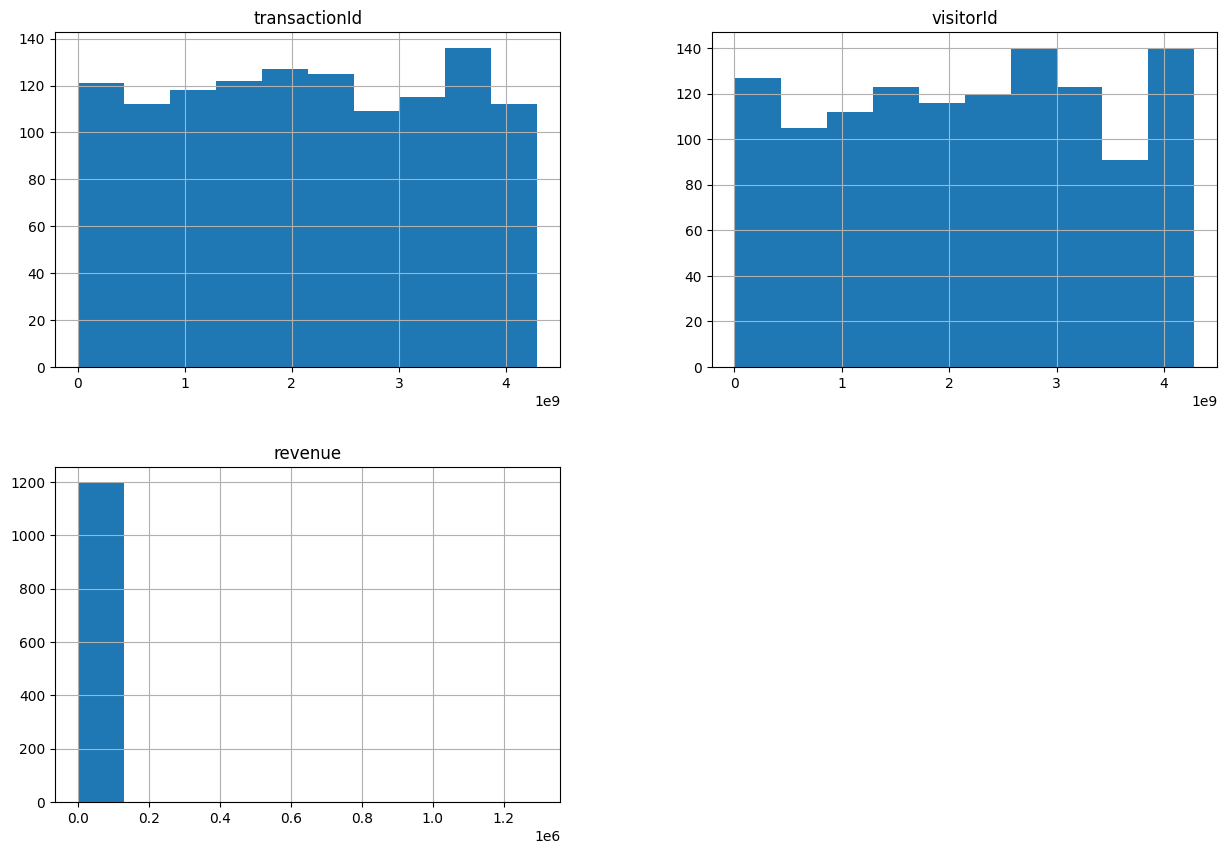

2024-05-01 19:47:07,639 - INFO - изменим название колонок:
2024-05-01 19:47:07,640 - INFO - ['transactionId', 'visitorId']
2024-05-01 19:47:07,642 - INFO - пропусков не нашел
2024-05-01 19:47:07,649 - INFO - дубликатов не найдено
2024-05-01 19:47:07,655 - INFO - поменяли на временной формат колоку
2024-05-01 19:47:07,657 - INFO - date
2024-05-01 19:47:07,659 - INFO - выдыхай, бобер, первичная обработка данных окончена
2024-05-01 19:47:07,661 - INFO - обработка гипотез завершена
2024-05-01 19:47:07,664 - INFO - обработка визитов
2024-05-01 19:47:07,935 - INFO - works online
2024-05-01 19:47:08,209 - INFO - read file sucsess
2024-05-01 19:47:08,211 - INFO - первое представление о данных


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


****************************************************************************************************


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


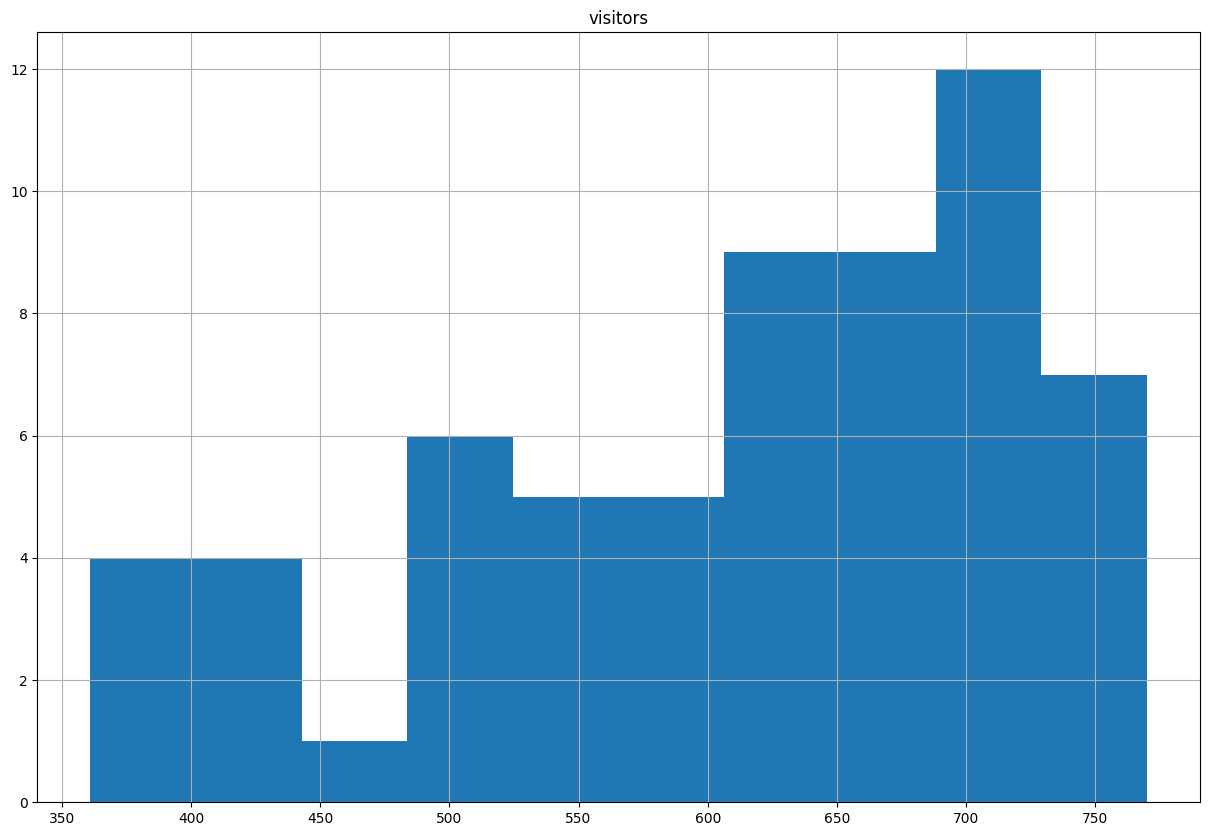

2024-05-01 19:47:08,479 - INFO - изменим название колонок:
2024-05-01 19:47:08,482 - INFO - []
2024-05-01 19:47:08,485 - INFO - пропусков не нашел
2024-05-01 19:47:08,490 - INFO - дубликатов не найдено
2024-05-01 19:47:08,493 - INFO - поменяли на временной формат колоку
2024-05-01 19:47:08,497 - INFO - date
2024-05-01 19:47:08,500 - INFO - выдыхай, бобер, первичная обработка данных окончена
2024-05-01 19:47:08,502 - INFO - обработка визитов завершена


In [4]:
logging.info('обработка гипотез')
hypoteses = process_data(os.getenv('dmb_h', ''), 'hypothesis.csv')
logging.info('обработка гипотез завершена')
logging.info('обработка заказов')
orders = process_data(os.getenv('dmb_o', ''), 'orders.csv')
logging.info('обработка гипотез завершена')
logging.info('обработка визитов')
visitors = process_data(os.getenv('dmb_v', ''), 'visitors.csv')
logging.info('обработка визитов завершена')

<h3>Часть 1. Приоритизация гипотез.</h3>

In [5]:
class PriorHyp:
    """Класс, внутри храняться вычесления по приоритизации гипотез"""

    def __init__(self, data: pd.DataFrame) -> None:
        self.__data = data
        required_columns = {'hypothesis', 'impact', 'confidence', 'efforts', 'reach'}
        if not required_columns.issubset(set(self.__data.columns)):
            raise ValueError('проверьте название колонок')

    @property
    def ice_p(self) -> pd.DataFrame:
        """Полные данные с вычесленной колонкой ICE"""
        self.__data['ICE'] = self.__data['impact'] * self.__data['confidence'] / self.__data['efforts']
        return self.__data[['hypothesis', 'impact', 'confidence', 'efforts', 'ICE']].sort_values(by='ICE', ascending=False)

    def present_ice(self):
        
        df = self.ice_p[['impact', 'confidence', 'efforts', 'ICE']] 
        fig = px.scatter_3d(df, x = 'impact', 
                            y = 'confidence', 
                            z = 'efforts', 
                            color = 'ICE') 

        fig.show()

    @property
    def rice_p(self) -> pd.DataFrame:
        """Полные данные с вычесленной колонкой RICE"""
        self.__data['RICE'] = self.__data['reach'] * self.__data['impact'] * self.__data['confidence'] / self.__data['efforts']
        return self.__data[['hypothesis', 'impact', 'confidence', 'efforts','reach', 'RICE']].sort_values(by='RICE', ascending=False)
  
    @property
    def __ice(self) -> pd.DataFrame:
        """Дата[гипотеза, ice]"""
        self.__data['ICE'] = self.__data['impact'] * self.__data['confidence'] / self.__data['efforts']
        return self.__data[['hypothesis', 'ICE']]

    @property
    def __rice(self):
        """Дата[гипотеза, rice]"""
        self.__data['RICE'] = self.__data['reach'] * self.__data['impact'] * self.__data['confidence'] / self.__data['efforts']
        return self.__data[['hypothesis', 'RICE']]
    
    def get_top_hypotheses(self, n=10):
        '''Возращает отсортированный фрейм с необходимыми колонками'''
        ice_df = self.__ice.sort_values(by='ICE', ascending=False).head(n)
        rice_df = self.__rice.sort_values(by='RICE', ascending=False).head(n)
        return ice_df, rice_df
    
    def get_hypothesis_scores(self) -> pd.DataFrame:
        """Возращает полность таблички, без сортировки"""
        ice_df = self.__ice
        rice_df = self.__rice
        return ice_df, rice_df

    def get_visualisation(self) -> None:        
        ice, rice = self.get_top_hypotheses(10)
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,12))
        ax[0].set_title('ICE')
        ax[0].hlines(y=range(1,len(ice.index)+1), xmin=0, xmax=ice['ICE'], color='skyblue')
        ax[0].plot(ice['ICE'], range(1,len(ice.index)+1), "o")
        ax[0].set_yticks(range(1,len(ice.index)+1))
        ax[0].set_yticklabels(ice['hypothesis'])

        ax[1].set_title('RICE')
        ax[1].hlines(y=range(1,len(rice.index)+1), xmin=0, xmax=rice['RICE'], color='skyblue')
        ax[1].plot(rice['RICE'], range(1,len(rice.index)+1), "o")
        ax[1].set_yticks(range(1,len(rice.index)+1))
        ax[1].set_yticklabels(rice['hypothesis'])


priority = PriorHyp(hypoteses)

ice, rice = priority.get_top_hypotheses()

,hypothesis,ICE
8,"запустить акцию, дающую скидку на товар в день...",16.200000
0,"добавить два новых канала привлечения трафика,...",13.333333
7,добавить форму подписки на все основные страни...,11.200000
6,показать на главной странице баннеры с актуаль...,8.000000
2,добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"запустить собственную службу доставки, что сок...",2.000000
5,"добавить страницу отзывов клиентов о магазине,...",1.333333
3,"изменить структура категорий, что увеличит кон...",1.125000
4,"изменить цвет фона главной страницы, чтобы уве...",1.000000


Text(0.5, 0.92, 'показатели ICE')

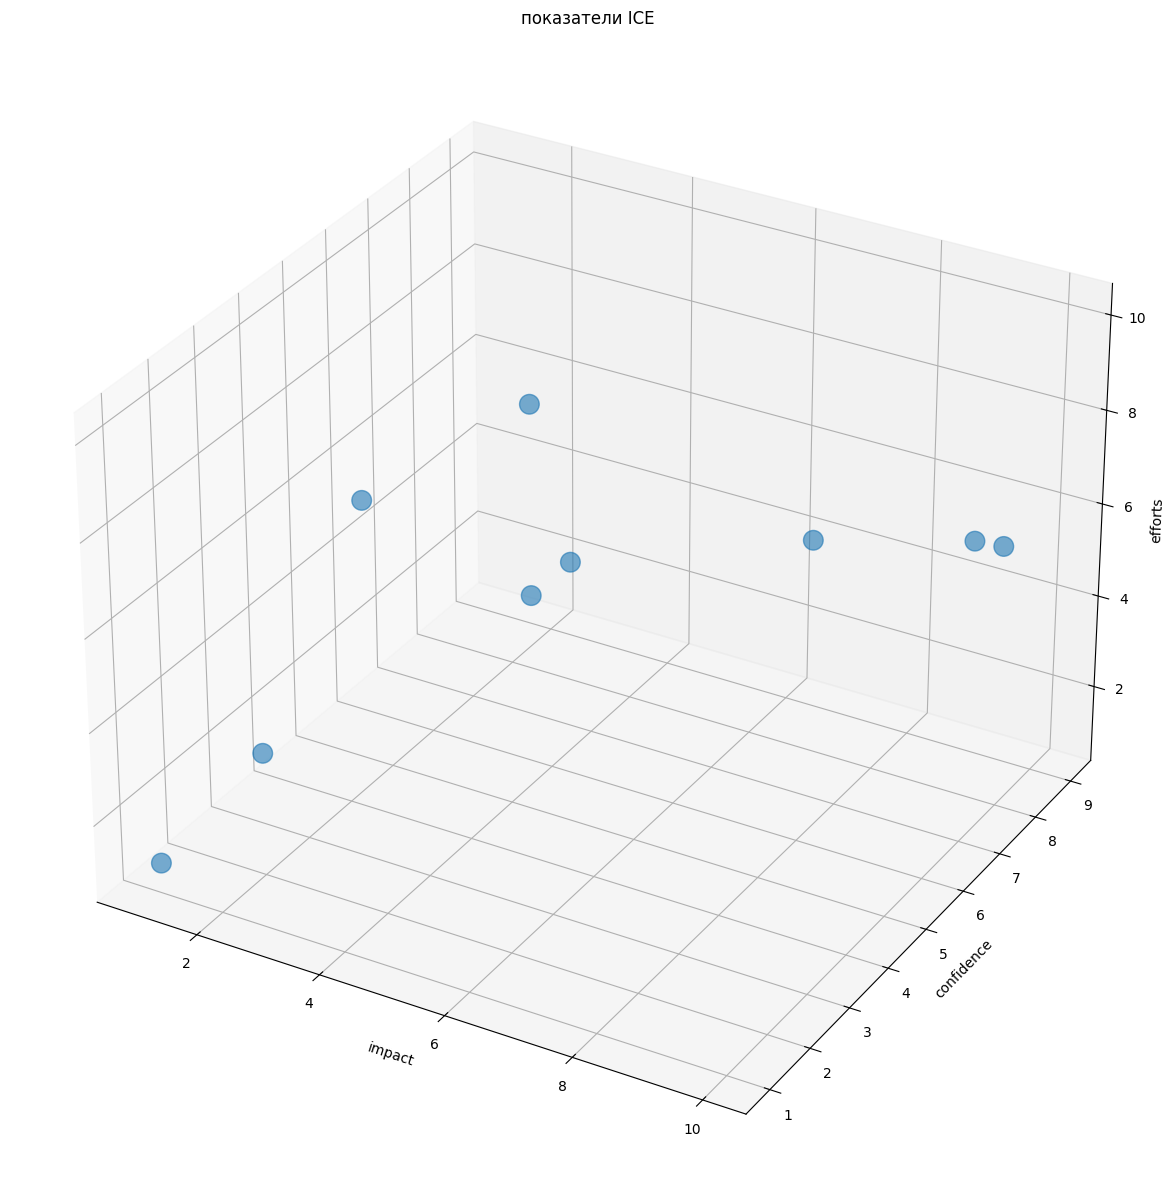

In [6]:
# Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
display(ice)

fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection="3d")
scatter = ax.scatter3D(priority.ice_p['impact'], priority.ice_p['confidence'], priority.ice_p['efforts'], s=200, alpha = .6, cmap='Set1')
ax.set_xlabel('impact')
ax.set_ylabel('confidence')
ax.set_zlabel("efforts")
ax.set_title("показатели ICE")

In [7]:
priority.present_ice()

In [8]:
# Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
rice

,hypothesis,RICE
7,добавить форму подписки на все основные страни...,112.0
2,добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"добавить два новых канала привлечения трафика,...",40.0
6,показать на главной странице баннеры с актуаль...,40.0
8,"запустить акцию, дающую скидку на товар в день...",16.2
3,"изменить структура категорий, что увеличит кон...",9.0
1,"запустить собственную службу доставки, что сок...",4.0
5,"добавить страницу отзывов клиентов о магазине,...",4.0
4,"изменить цвет фона главной страницы, чтобы уве...",3.0


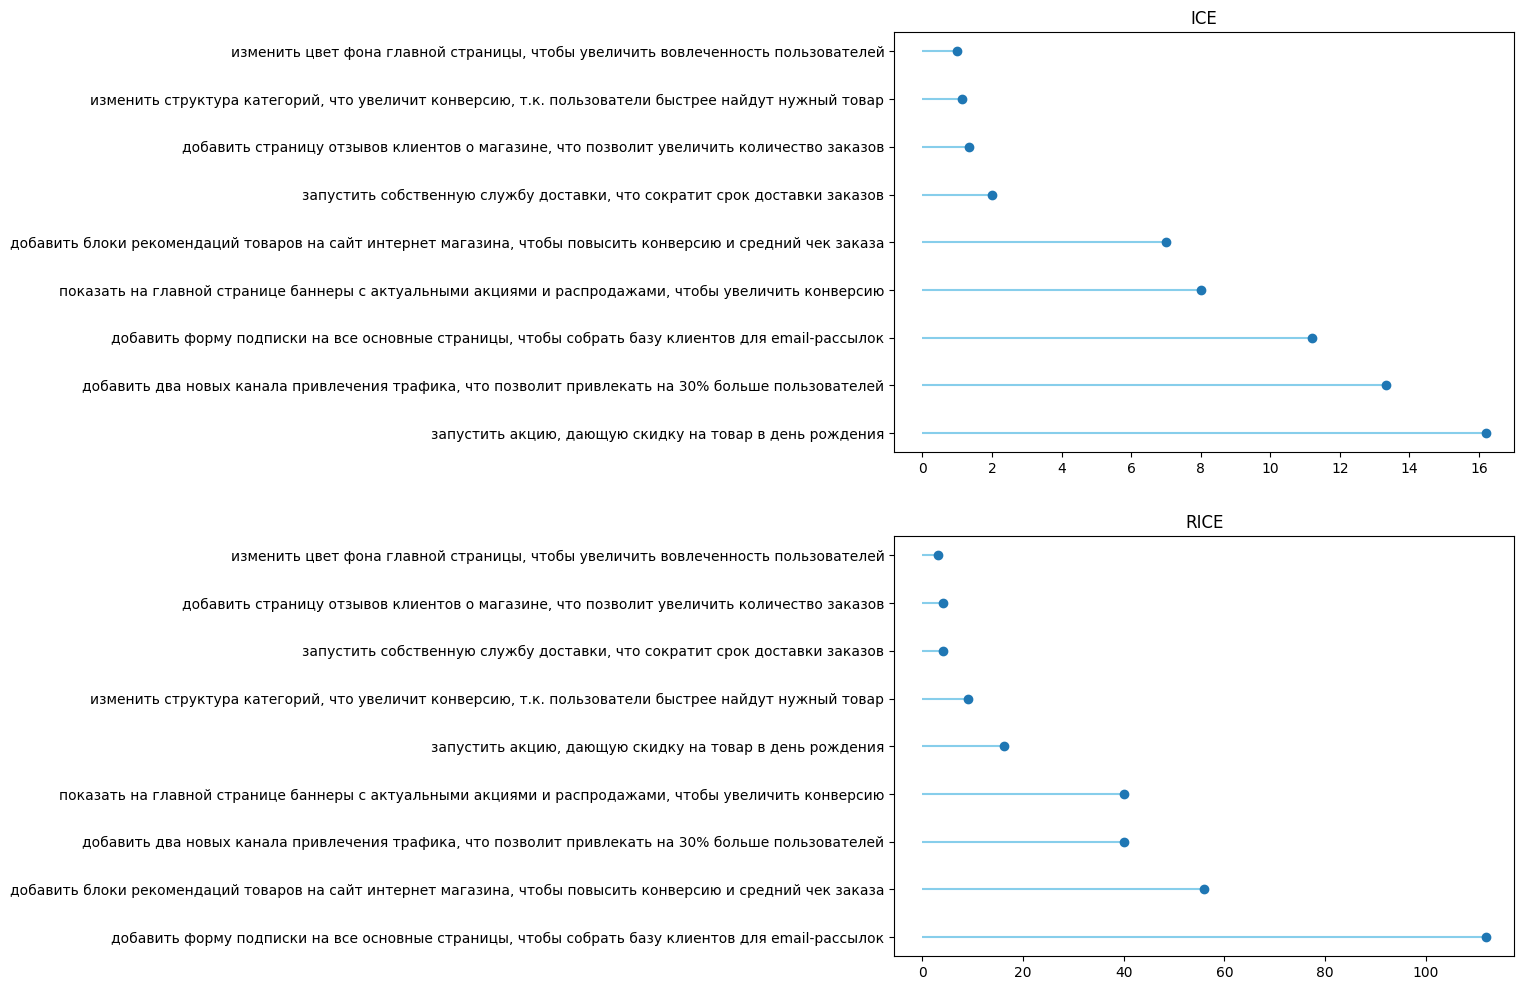

In [9]:
# Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE.
priority.get_visualisation()

Изменения:
- Гипотеза, которая занимала первое место в ICE спустилась на пятое место по RICE
- Лучшая гипотеза по RICE, занимает 5 место по ICE

2024-05-01 19:47:14,566 - INFO - Показатели (по ICE) двух лучших гипотез по ICE


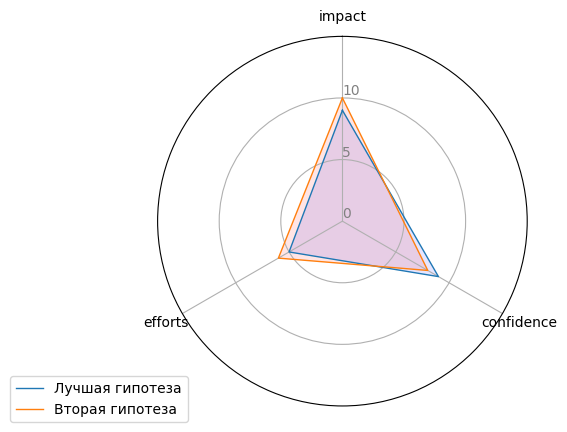

2024-05-01 19:47:14,798 - INFO - Показатели (по RICE) двух лучших гипотез по RICE


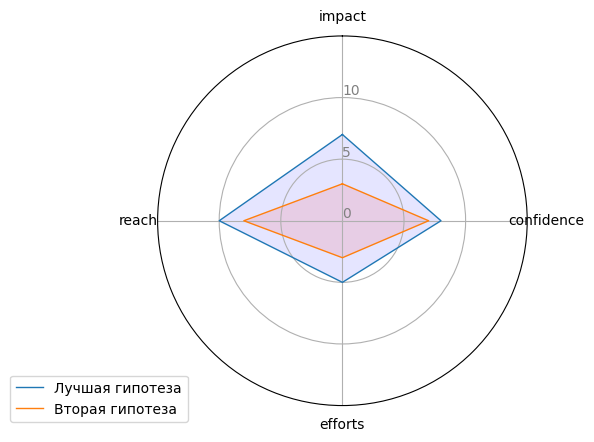

2024-05-01 19:47:15,003 - INFO - Показатели (по RICE) двух лучших гипотез по ICE


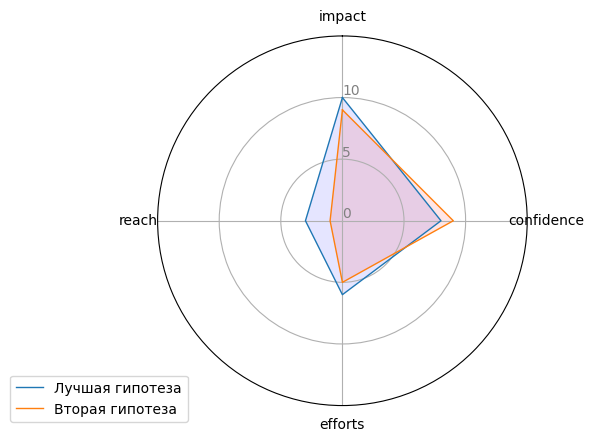

2024-05-01 19:47:15,239 - INFO - Показатели (по ICE) двух лучших гипотез по RICE


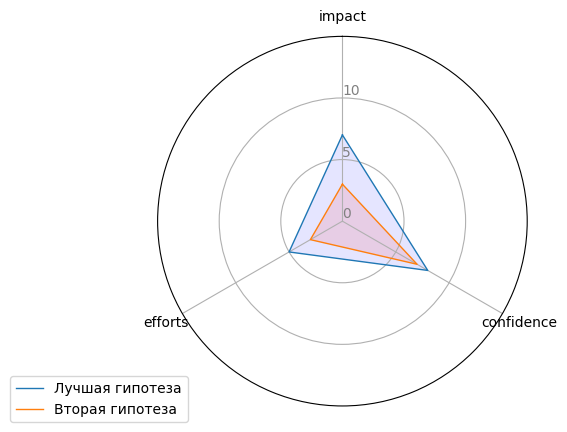

In [10]:
# Объясните, почему так произошло.

def get_explanation(df):
    categories = list(df)[1:]
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([0, 5, 10], ["0","5","10"], color="grey", size=10)
    plt.ylim(0,15)
    values= df.loc[0].drop('hypothesis').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Лучшая гипотеза")
    ax.fill(angles, values, 'b', alpha=0.1)
    values=df.loc[1].drop('hypothesis').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Вторая гипотеза")
    ax.fill(angles, values, 'r', alpha=0.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show();

leaders_ice = priority.ice_p['hypothesis'].head(2).to_list()
leaders_rice = priority.rice_p['hypothesis'].head(2).to_list()

df = priority.ice_p[['hypothesis', 'impact', 'confidence', 'efforts']].reset_index().drop(columns='index')
df_1 = priority.rice_p[['hypothesis', 'impact', 'confidence', 'efforts', 'reach']].reset_index().drop(columns='index')
df_2 = priority.rice_p.query('hypothesis in @leaders_ice')[['hypothesis', 'impact', 'confidence', 'efforts', 'reach']].reset_index().drop(columns='index')
df_3 = priority.ice_p.query('hypothesis in @leaders_rice')[['hypothesis', 'impact', 'confidence', 'efforts']].reset_index().drop(columns='index')

logging.info('Показатели (по ICE) двух лучших гипотез по ICE')
get_explanation(df)
logging.info('Показатели (по RICE) двух лучших гипотез по RICE')
get_explanation(df_1)
logging.info('Показатели (по RICE) двух лучших гипотез по ICE')
get_explanation(df_2)
logging.info('Показатели (по ICE) двух лучших гипотез по RICE')
get_explanation(df_3)

Гипотезы, которые по ICE выглядят наиболее привлекательными, имеют достаточно низкий REACH

<h3>Часть 2. Анализ A/B-теста</h3>

Построим график кумулятивной выручки по группам.

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,a,24,20,148579,719
1,2019-08-01,b,21,20,101217,713
2,2019-08-02,a,44,38,242401,1338
3,2019-08-02,b,45,43,266748,1294
4,2019-08-03,a,68,62,354874,1845


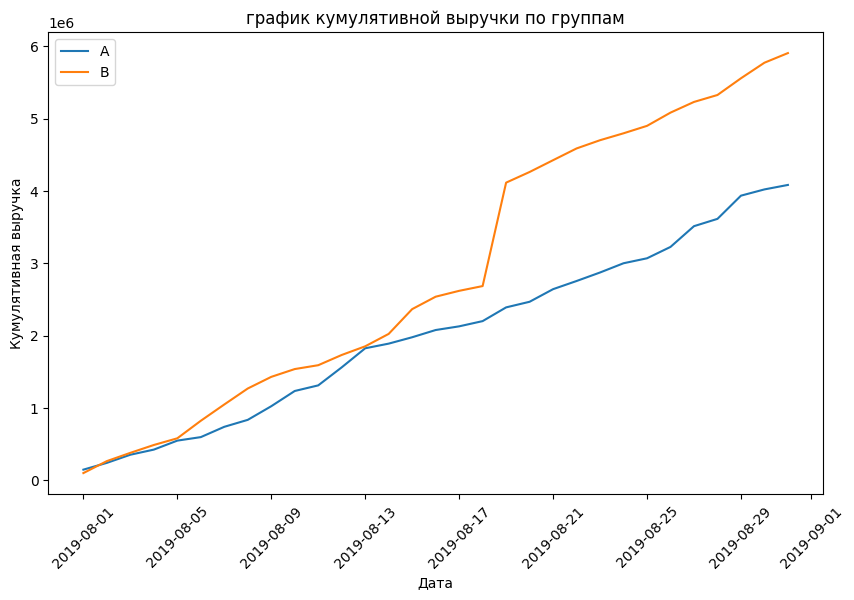

In [11]:
# Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
datesGroups = orders[['date','group']].drop_duplicates()


ordersAggregated = (datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                                      orders['group'] == x['group'])]
                                      .agg({'date' : 'max', 'group' : 'max',
                                            'transaction_id' : 'nunique', 'visitor_id' : 'nunique',
                                            'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group']))

visitorsAggregated = (datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                                          visitors['group'] == x['group'])]
                                        .agg({'date' : 'max',
                                              'group' : 'max',
                                              'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group']))

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulativeData.head(5))

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='a'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='b'][['date','revenue', 'orders']]

plt.figure(figsize=(10, 6))
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Кумулятивная выручка')
plt.title('График кумулятивной выручки по группам')

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('график кумулятивной выручки по группам')
plt.legend()
plt.show();

Выводы:
- Выручка по группе B на протяжении всего периода превышает выручку в группе A.
- Однако графики выручки обеих групп в нескольких точках резко растут. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

Построим график кумулятивного среднего чека по группам.

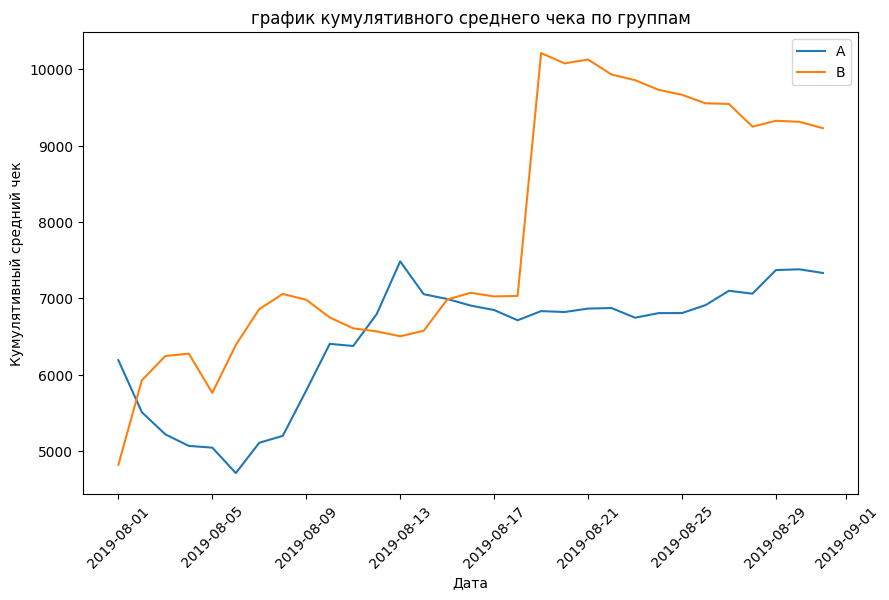

In [12]:
# Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

plt.figure(figsize=(10, 6))
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Кумулятивный средний чек')
plt.title('график кумулятивного среднего чека по группам')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.show();


Средний чек проявляет флукционность на протяжении всего периода. Особенно ярко выражена аномальность в резком скачке для группы B в середине периода. Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A

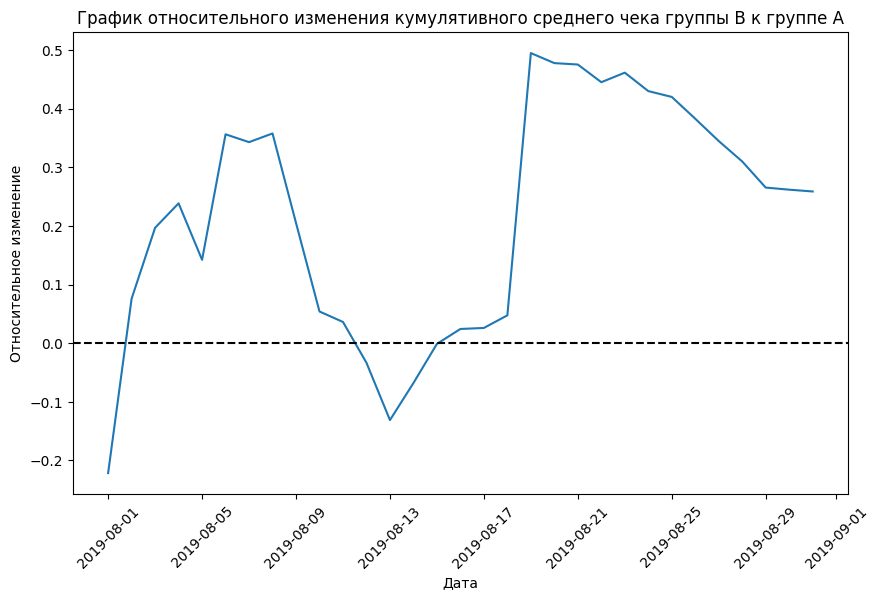

In [13]:
# Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(10, 6))
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Относительное изменение')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.show();

В нескольких точках график различия между сегментами резко «скачет». Что подтверждает наличие выбросов

Построим график кумулятивного среднего количества заказов на посетителя по группам

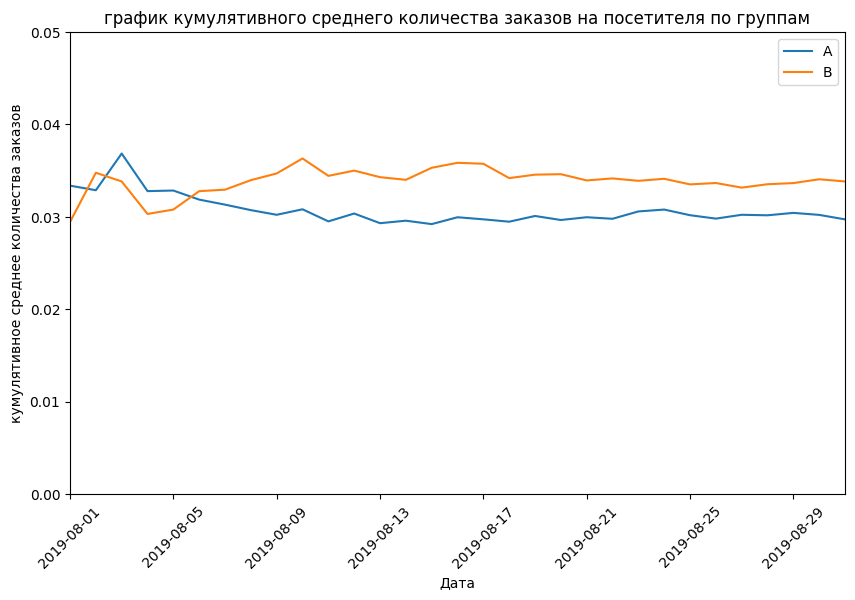

In [14]:
# Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='a']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='b']

# строим графики
plt.figure(figsize=(10, 6))
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('кумулятивное среднее количества заказов')
plt.title('график кумулятивного среднего количества заказов на посетителя по группам')
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([cumulativeDataA['date'].min().date(), cumulativeDataA['date'].max().date(), 0, 0.05])
plt.show();

Из графика кумулятивного количества заказов по группам видно, что группа B также опережает группу A на протяжении всего теста.

Однако, как и в случае с кумулятивным средним чеком, в группе B произошел резкий скачок количества заказов в начале теста, что может быть связано с аномальными заказами. После этого скачка колебания кумулятивного количества заказов в группе B также стабилизировались.

Таким образом, на данный момент группа B является лидером по кумулятивному количеству заказов, но необходимо провести дополнительный анализ, чтобы понять, какие именно заказы повлияли на такой резкий рост количества заказов в группе B.

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

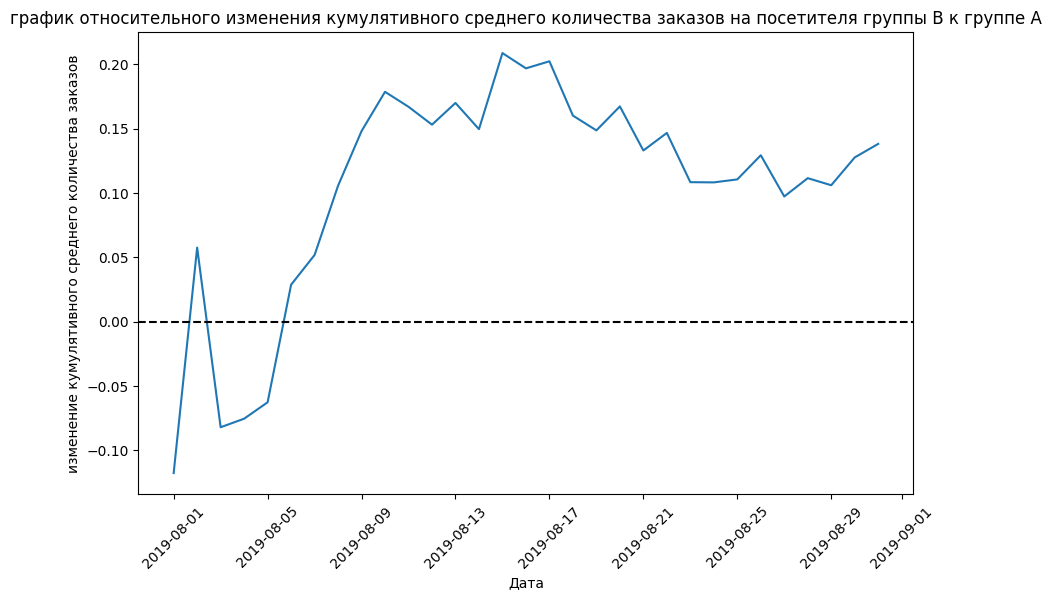

In [15]:
# Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.
# собираем данные в одном датафрейме

mergedCumulativeConversation = cumulativeDataA.merge(cumulativeDataB,
                                                     left_on='date',
                                                     right_on='date',
                                                     how='left',
                                                     suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(10, 6))
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('изменение кумулятивного среднего количества заказов')
plt.title('график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.plot(mergedCumulativeConversation['date'],
         (mergedCumulativeConversation['ordersB']/mergedCumulativeConversation['visitorsB'])/(mergedCumulativeConversation['ordersA']/mergedCumulativeConversation['visitorsA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.show();

По графику видна сильная флуктуация относительного изменения, особенно ярко выраженная в начале теста и стабилизирующаяся в интервале от 10-15% к концу.

Построим точечный график количества заказов по пользователям.

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


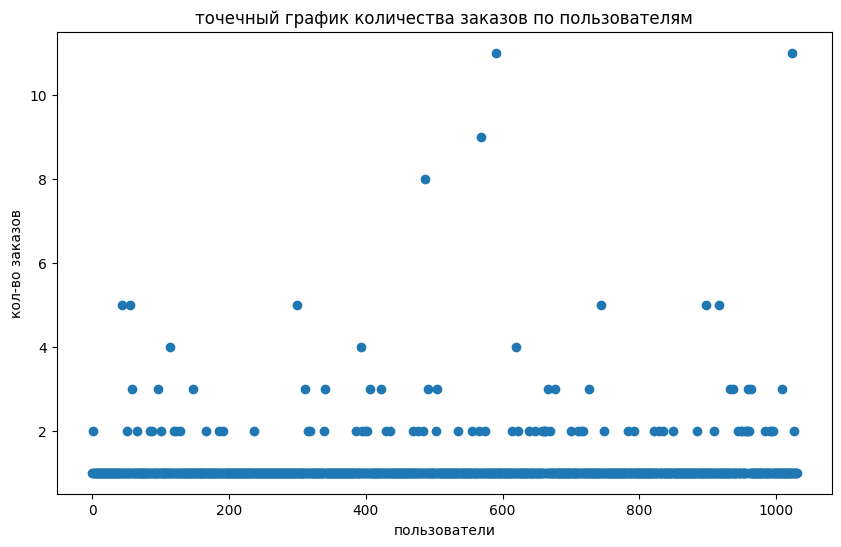

In [16]:
# Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

display(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

plt.figure(figsize=(10, 6))
plt.xlabel('пользователи')
plt.ylabel('кол-во заказов')
plt.title('точечный график количества заказов по пользователям')

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.show();

как и предполагалось, обнаружились выбросы. Видно, что большая часть юзеров делали не более одного заказа

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [17]:
# Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% юзеров не совершали более 2 заказов и не более 1% - 4.

Пусть граница выбросов будет состовлять 5%, тогда граница для определения аномальных пользователей по кол-ву заказов - менее 2 заказов

Построим точечный график стоимостей заказов

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,b
1196,3936777065,2108080724,2019-08-15,202740,b
858,192721366,1316129916,2019-08-27,93940,a
1136,666610489,1307669133,2019-08-13,92550,a
744,3668308183,888512513,2019-08-27,86620,b
682,1216533772,4266935830,2019-08-29,78990,b
662,1811671147,4266935830,2019-08-29,78990,a
743,3603576309,4133034833,2019-08-09,67990,a
1103,1348774318,1164614297,2019-08-12,66350,a
1099,316924019,148427295,2019-08-12,65710,a


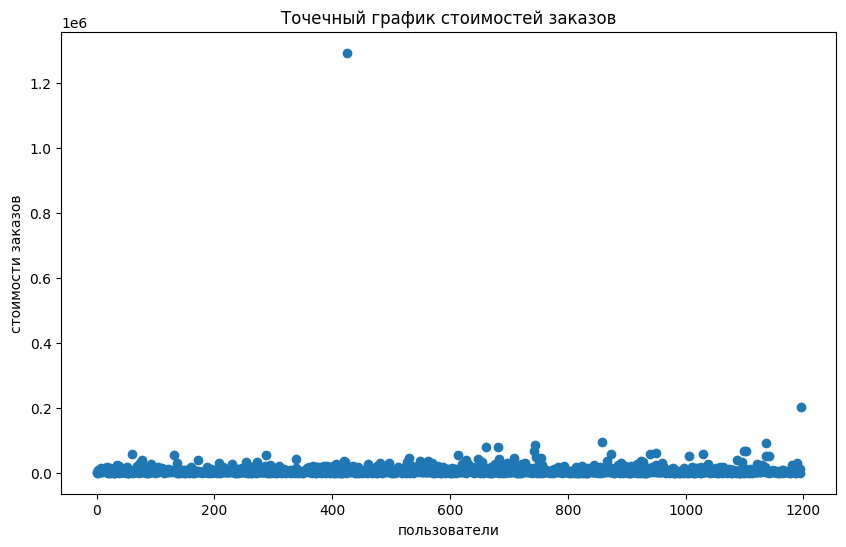

In [18]:
# Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

display(orders.sort_values(by='revenue', ascending=False).head(10))
plt.figure(figsize=(10, 6))
plt.xlabel('пользователи')
plt.ylabel('стоимости заказов')
plt.title('Точечный график стоимостей заказов')
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.show();

по графику легко обнаружить наличие выбросов

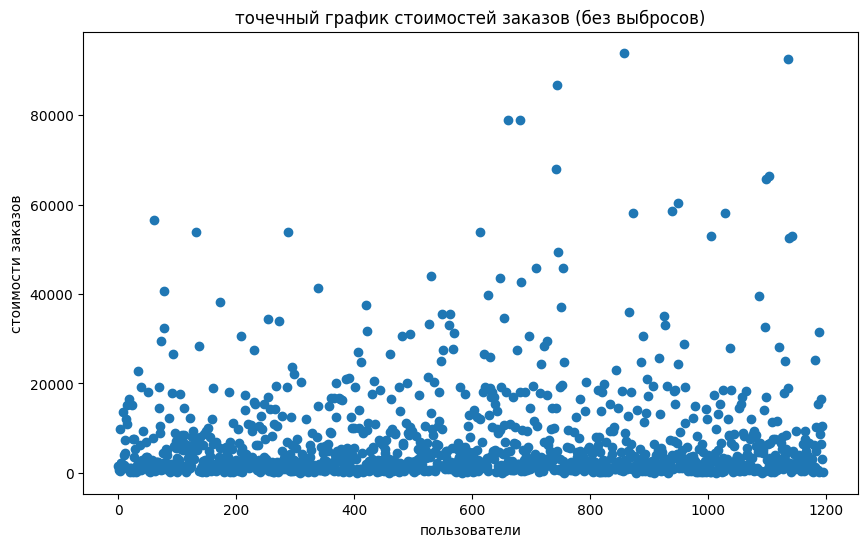

In [19]:
# Давай сделаем еще один график без выбросов

plt.figure(figsize=(10, 6))
border = 100_000
plt.xlabel('пользователи')
plt.ylabel('стоимости заказов')
plt.title('точечный график стоимостей заказов (без выбросов)')
data_filter_revenue = orders.query('revenue < @border')['revenue']
x_values = pd.Series(range(len(data_filter_revenue)))
plt.scatter(x_values, data_filter_revenue)
plt.show();

In [20]:
# проанализировать распределение основного числа заказов

def is_distribution_normal(distribution, alpha):
    results = st.shapiro(distribution)
    p_value = results[1]
    if p_value < alpha:
        return f'При уровне значимости {alpha} oтвергаем нулевую гипотезу: распределение не нормально'
    return f'При уровне значимости {alpha} не получилось отвергнуть нулевую гипотезу, всё нормально'

print('стоимости заказов:', is_distribution_normal(data_filter_revenue, .05))

стоимости заказов: При уровне значимости 0.05 oтвергаем нулевую гипотезу: распределение не нормально


In [21]:
# Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233 рублей.

Пусть граница выбросов будет состовлять 5%, тогда граница для определения аномальных пользователей по стоимости заказов - менее 28_000

По сырым данным

- H0: В группах нет статистичнски значимых различий в среднем количестве заказов на посетителя
- H1: В группах есть статистичнски значимые различия в среднем количестве заказов на посетителя

При проверке будем использовать непараметрический тест Уилкоксона-Манна-Уитни, так как данные распределены ненормально. Уровень критической значимости оставим равным 5%

In [22]:
# Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.
# Сделайте выводы и предположения.

visitorsADaily = visitors[visitors['group'] == 'a'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'b'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'a'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'b'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'a']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'b']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = (
    orders[orders['group'] == 'a']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'b']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("p-value: {0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("отношение B к A: {0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

p-value: 0.01679
отношение B к A: 0.138


Вывод:
- По «сырым» данным различия в среднем числе заказов групп A и B имеются. 
- p-value = 0.0167 менее 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет,отвергаем. Относительный выигрыш группы B равен 13.8%.

По сырым данным

- H0: В группах нет статистичнски значимых различий в среднем чеке заказа
- H1: В группах есть статистичнски значимые различия в среднем чеке заказа

In [23]:
# Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
print('p-value: {0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='a']['revenue'], orders[orders['group']=='b']['revenue'])[1]))
print('отношение: {0:.3f}'.format(orders[orders['group']=='b']['revenue'].mean()/orders[orders['group']=='a']['revenue'].mean()-1))

p-value: 0.729
отношение: 0.259


Вывод:
- P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.
- Впрочем, средний чек группы B значительно выше среднего чека группы A.

по «очищенным» данным

- H0: В группах нет статистичнски значимых различий в среднем количестве заказов на посетителя
- H1: В группах есть статистичнски значимые различия в среднем количестве заказов на посетителя

In [24]:
# Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28_000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('p-value: {0:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])) 
print('отношение: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.01304
отношение: 0.173


Вывод:
- Результаты по среднему количеству заказов практически не изменились.
- По «очищенным» данным различия в среднем числе заказов групп A и B имеются.
- p-value = 0.013 менее 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет,отвергаем. 
- Относительный выигрыш группы B равен 17%

По очищенным данным

- H0: В группах нет статистичнски значимых различий в среднем чеке заказа
- H1: В группах есть статистичнски значимые различия в среднем чеке заказа

In [25]:
# Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
print(
    'p-value: {0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'a',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'b',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "отношение: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'b',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'a',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.738
отношение: -0.020


Выводы:
- P-value сильно не изменился, а значит принимаем нулевую гипотезу
- однако прирост стал отризательным с фильтрацией выбросов

In [26]:
# Примите решение по результатам теста и объясните его. Варианты решений:
# 1. Остановить тест, зафиксировать победу одной из групп.
# 2. Остановить тест, зафиксировать отсутствие различий между группами.
# 3. Продолжить тест.
print('Остановить тест, зафиксировать победу одной из групп.')

Остановить тест, зафиксировать победу одной из групп.


<h3> Выводы</h3>

Выводы:
- Есть статистически значимое различия по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий. Группа B - лидирует;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- Проведенв обработка данных
- сделана приоритизация гипотез
- Проведено A/B-тестирование


Принимаем решение остановить тест и зафиксировать победу группы B, т.к. она показывает более высокие результаты по среднему количеству заказов что приведет к увеличению выручки